# Part 2: Data Ingestion

# 2.1. Populate the Database

In [78]:
from pymongo import MongoClient
client = MongoClient('mongodb://localhost:27017') 
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [79]:
db = client["stock_market"]

# Collections
stocks = db["stocks"]
historical_prices = db["historical_prices"]
real_time_prices = db["real_time_prices"]
market_events = db["market_events"]

# Populate Stocks and Historical Prices Collection
Populate these collections with data of 3 stocks: CBA.AX, BHP.AX and WOW.AX

In [3]:
import yfinance as yf
import pymongo
import datetime

# Create unique index on stock_symbol in Stocks collection 
stocks.create_index([("stock_symbol", pymongo.ASCENDING)], unique=True)

# Function to fetch stock info
def populate_stocks(symbols):
    for symbol in symbols:
        try:
            stock = yf.Ticker(symbol)
            stock_info = stock.info

            stock_data = {
                "stock_symbol": symbol,
                "company_name": stock_info.get("longName", "N/A"),
                "sector": stock_info.get("sector", "N/A"),
                "market_cap": stock_info.get("marketCap", 0),
                "exchange": stock_info.get("exchange", "N/A"),
            }

            # Insert or update stock data to avoid duplicates
            stocks.update_one(
                {"stock_symbol": symbol},  
                {"$set": stock_data},       
                upsert=True               
            )
            print(f"Inserted or updated data for {symbol} in Stocks collection.")
        except Exception as e:
            print(f"Error fetching or inserting stock data for {symbol}: {e}")

# Function to fetch historical prices (last 3 month)
def populate_historical_prices(symbol):
    try:
        ticker = yf.Ticker(symbol)
        history = ticker.history(period="3mo")
        if history.empty:
            print(f"No historical data for {symbol}.")
            return
        
        for date, row in history.iterrows():
            historical_prices.insert_one({
                "stock_symbol": symbol,
                "date": date.to_pydatetime(),
                "open": row["Open"],
                "close": row["Close"],
                "high": row["High"],
                "low": row["Low"],
                "volume": int(row["Volume"])
            })
        print(f"Historical prices inserted for {symbol}.")
    except Exception as e:
        print(f"Error fetching or inserting historical prices for {symbol}: {e}")

symbols = ["CBA.AX", "BHP.AX", "WOW.AX"]

# Populate stock info
populate_stocks(symbols)

# Populate historical prices for each symbol
for symbol in symbols:
    populate_historical_prices(symbol)

C:\Users\ngochuyen\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\ngochuyen\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Inserted or updated data for CBA.AX in Stocks collection.
Inserted or updated data for BHP.AX in Stocks collection.
Inserted or updated data for WOW.AX in Stocks collection.
Historical prices inserted for CBA.AX.
Historical prices inserted for BHP.AX.
Historical prices inserted for WOW.AX.


# Populate Real-Time Prices Collection

In [15]:
# Function to fetch real-time prices
def populate_real_time_prices(symbol):
    try:
        ticker = yf.Ticker(symbol)
        history = ticker.history(period="1d", interval="1m")
        if history.empty:
            print(f"No real-time data for {symbol}.")
            return
        
        latest_data = history.iloc[-1]
        # Insert real-time price data
        real_time_prices.insert_one({
            "stock_symbol": symbol,
            "timestamp": datetime.datetime.utcnow(),
            "price": latest_data["Close"],
            "volume": int(latest_data["Volume"])
        })
        print(f"Real-time price inserted for {symbol}.")
    except Exception as e:
        print(f"Error fetching or inserting real-time prices for {symbol}: {e}")

# Example usage
symbols = ["CBA.AX", "BHP.AX", "WOW.AX"]



The code was manually executed six times, with at least a **1-minute interval** between runs to match yfinance's minute-level data granularity, resulting in 18 entries in the Real-time Prices collection.

In [13]:
#Populate real-time prices for each symbol
for symbol in symbols:
    populate_real_time_prices(symbol)

Real-time price inserted for CBA.AX.
Real-time price inserted for BHP.AX.
Real-time price inserted for WOW.AX.


In [71]:
real_time_prices.count_documents({})

18

# Populate Live Commentary Collection

At this stage, the commentary was generated after populating the Real-Time Prices collection in chronological order. While this approach traded off real-time updates, it ensured time-sequenced commentary generation.

In [44]:
# Function to generate live commentary
live_commentary = db["live_commentary"]
def generate_live_commentary_from_db(symbol):
    try:
        # Fetch all prices for the symbol from the database, sorted by timestamp
        prices = list(real_time_prices.find({"stock_symbol": symbol}).sort("timestamp", 1))
        
        if not prices:
            print(f"No data found for {symbol}.")
            return
        
        # Generate commentary for each price entry (skip the first one for comparison)
        prev_price = None
        for entry in prices:
            current_price = entry["price"]
            timestamp = datetime.datetime.utcnow()
            
            if prev_price is None:
                # Set the initial price without commentary
                prev_price = current_price
                continue
            
            # Calculate percentage change
            price_change_percentage = ((current_price - prev_price) / prev_price) * 100
            
            # Generate commentary
            if price_change_percentage > 0:
                commentary = f"At {timestamp}, the stock price of {symbol} increased by {price_change_percentage:.2f}%."
            elif price_change_percentage < 0:
                commentary = f"At {timestamp}, the stock price of {symbol} decreased by {abs(price_change_percentage):.2f}%."
            else:
                commentary = f"At {timestamp}, the stock price of {symbol} did not change."
            
            # Insert the commentary into the live_commentary collection
            live_commentary.insert_one({
                "stock_symbol": symbol,
                "timestamp": timestamp,
                "content": commentary
            })
            
            print(f"Commentary inserted for {symbol}: {commentary}")
            
            # Update the previous price for the next iteration
            prev_price = current_price
    except Exception as e:
        print(f"Error generating commentary for {symbol}: {e}")

# Generate commentary for 3 stocks
for symbol in symbols:
    generate_live_commentary_from_db(symbol)


Commentary inserted for CBA.AX: At 2024-12-09 05:27:20.853785, the stock price of CBA.AX increased by 0.03%.
Commentary inserted for CBA.AX: At 2024-12-09 05:27:20.864209, the stock price of CBA.AX increased by 0.03%.
Commentary inserted for CBA.AX: At 2024-12-09 05:27:20.866216, the stock price of CBA.AX increased by 0.06%.
Commentary inserted for CBA.AX: At 2024-12-09 05:27:20.867198, the stock price of CBA.AX decreased by 0.01%.
Commentary inserted for CBA.AX: At 2024-12-09 05:27:20.868195, the stock price of CBA.AX decreased by 0.01%.
Commentary inserted for BHP.AX: At 2024-12-09 05:27:20.871185, the stock price of BHP.AX decreased by 0.01%.
Commentary inserted for BHP.AX: At 2024-12-09 05:27:20.872183, the stock price of BHP.AX increased by 0.01%.
Commentary inserted for BHP.AX: At 2024-12-09 05:27:20.873182, the stock price of BHP.AX increased by 0.01%.
Commentary inserted for BHP.AX: At 2024-12-09 05:27:20.874179, the stock price of BHP.AX decreased by 0.02%.
Commentary inserted

# Populate Market Events Collection with csv file

In [19]:
# Approach 3: Populate market events collection by csv file
import pandas as pd
import random
from textblob import TextBlob

# Sentiment analysis function
def analyze_sentiment(title, description):
    text = f"{title} {description}"  # Combine both fields for sentiment analysis
    if text:
        analysis = TextBlob(text)
        sentiment_score = analysis.sentiment.polarity
        if sentiment_score > 0:
            return "Positive"
        elif sentiment_score < 0:
            return "Negative"
        else:
            return "Neutral"
    return "Neutral"  # Default for empty or missing text

# Load the CSV file
csv_file_path = "market_events_data.csv"
df = pd.read_csv(csv_file_path)

# Convert the Date column to datetime format
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Populate the collection
for _, row in df.iterrows():
    title = row.get("Title", "N/A")
    description = row.get("Description", "N/A")
    symbol = row.get("Stock Symbol", "N/A")
    
    # Analyze sentiment
    sentiment = analyze_sentiment(title, description)
    
    # Create event data
    event_data = {
        "event_id": row.get("URL", "N/A"),  # Use URL as a unique identifier
        "title": title,
        "description": description,
        "sentiment": sentiment,
        "source": row.get("Source", "Unknown"),
        "date": row["Date"].to_pydatetime() if not pd.isna(row["Date"]) else None,
        "related_stocks": symbol
    }

    try:
        db.market_events.insert_one(event_data)
    except Exception as e:
        print(f"Error inserting document: {e}")

# Confirmation message after the loop finishes
print("All market events have been successfully inserted.")

All market events have been successfully inserted.


In [47]:
#Approach 1: Fetch data via NewsAPI using requests.get()
"""import requests
import datetime

# News API Key and URL
NEWS_API_KEY = "aea93ff98b694c80b6b0299855f358fe"
NEWS_API_URL = "https://newsapi.org/v2/everything"

# Fetch the list of stock symbols, company names, and sectors from the database
def get_stock_data():
    stock_docs = stocks.find({}, {"stock_symbol": 1, "company_name": 1, "sector": 1, "_id": 0})
    stock_mappings = {}
    for doc in stock_docs:
        stock_mappings[doc["stock_symbol"]] = {
            "company_name": doc.get("company_name", ""),
            "sector": doc.get("sector", ""),
        }
    return stock_mappings

# Function to dynamically extract related stocks from article text using stock data
def extract_related_stocks(article_text, stock_mappings):
    related_stocks = set()
    for symbol, info in stock_mappings.items():
        # Match by stock symbol or company name
        if symbol in article_text or info["company_name"].lower() in article_text.lower():
            related_stocks.add(symbol)
    return list(related_stocks)

# Fallback: Assign sectors if no specific stock is matched
def assign_sector(article_text, stock_mappings):
    matched_sectors = set()
    for symbol, info in stock_mappings.items():
        if info["sector"].lower() in article_text.lower():
            matched_sectors.add(info["sector"])
    return list(matched_sectors)

# Populate market events with improved stock linkage
def populate_market_events():
    stock_mappings = get_stock_data()

    response = requests.get(NEWS_API_URL, params={
        "q": "ASX stocks",
        "apiKey": NEWS_API_KEY,
        "language": "en",
        "sortBy": "publishedAt"
    })

    articles = response.json().get("articles", [])
    for article in articles:
        # Combine title, description, and content for broader context
        article_text = article["title"] + " " + (article["description"] or "") + " " + (article.get("content") or "")
        related_stocks = extract_related_stocks(article_text, stock_mappings)
        
        # If no stocks are matched, try sectors
        if not related_stocks:
            related_sectors = assign_sector(article_text, stock_mappings)
            if related_sectors:
                related_stocks = related_sectors
            else:
                related_stocks = "General Market"

        market_events.insert_one({
            "event_id": article["url"],
            "title": article["title"],
            "source": article["source"]["name"],
            "date": datetime.datetime.strptime(article["publishedAt"], '%Y-%m-%dT%H:%M:%SZ'),
            "description": article["description"],
            "url": article["url"],
            "related_stocks": related_stocks
        })
    
    print("Market events collection populated with enhanced stock linking.")

# Run the function
if __name__ == "__main__":
    populate_market_events()
"""


Market events collection populated with enhanced stock linking.


In [6]:
#Approach 2: Use the stock.news method from the yfinance library to fetch news directly related to specific stock symbols
"""
def populate_market_events(symbol):
    stock = yf.Ticker(symbol)
    news_data = stock.news  # Get news data from Yahoo Finance

    for article in news_data:
        event_data = {
            "event_id": article.get("link", "N/A"),
            "title": article.get("title", "N/A"),
            "source": article.get("publisher", "Unknown"),  # Use 'publisher' for source
            "date": datetime.datetime.fromtimestamp(article.get("providerPublishTime", 0)),  # Convert Unix timestamp to datetime
            "related_stocks": symbol,
        }
        db.market_events1.insert_one(event_data)
    print(f"Inserted market events for {symbol} into Market Events collection.")
"""

# 2.2. Data Consistency

In [20]:
#Q1:Ensure that every stock symbol in Historical Prices, Real-time Prices collection exists in the Stocks collection.
def check_stock_symbols(source_collection, source_field, stocks_collection="stocks"):
    symbols = set(doc[source_field] for doc in db[source_collection].find({}, {source_field: 1}))
    stock_symbols = set(doc["stock_symbol"] for doc in db[stocks_collection].find({}, {"stock_symbol": 1}))
    
    inconsistent = symbols - stock_symbols
    if inconsistent:
        print(f"Warning: The following symbols in {source_collection} are not found in the Stocks collection: {inconsistent}.")
    else:
        print(f"All symbols in {source_collection} are consistent with the Stocks collection.")

In [21]:
check_stock_symbols("historical_prices", "stock_symbol")
check_stock_symbols("real_time_prices", "stock_symbol")

All symbols in historical_prices are consistent with the Stocks collection.
All symbols in real_time_prices are consistent with the Stocks collection.


In [26]:
# Q2: Verify market events are linked to valid stocks
def check_market_event_stock_links():
    invalid_events = market_events.aggregate([
        {"$unwind": "$related_stocks"},
        {"$lookup": {
            "from": "stocks",
            "localField": "related_stocks",
            "foreignField": "stock_symbol",
            "as": "stock_info"
        }},
        {"$match": {"stock_info": {"$size": 0}}},
        {"$project": {"title": 1, "related_stocks": 1}}
    ])
    results = list(invalid_events)
    if results:
        print("Inconsistent data: Some market events reference invalid stocks:", results)
    else:
        print("All market events are properly linked to valid stocks.")
check_market_event_stock_links()

All market events are properly linked to valid stocks.


In [27]:
#Q3:Check if dates in Historical Prices match the date of the Real-time Prices
# Check if the latest price in Historical Prices matches the last recorded Real-time Price for each stock.
def check_dates_in_prices():
    # Get all unique stock symbols from Historical Prices collection
    historical_symbols = [doc["stock_symbol"] for doc in historical_prices.find({}, {"stock_symbol": 1})]
    
    for symbol in historical_symbols:
        # Fetch the latest date from Historical Prices
        last_historical = list(historical_prices.find({"stock_symbol": symbol}).sort("date", pymongo.DESCENDING).limit(1))
        
        # Fetch the latest timestamp from Real-time Prices
        real_time_data = list(real_time_prices.find({"stock_symbol": symbol}).sort("timestamp", pymongo.DESCENDING).limit(1))
        
        if last_historical and real_time_data:
            # Extract dates from the documents
            historical_date = last_historical[0]["date"].date()
            real_time_date = real_time_data[0]["timestamp"].date()
            
            # Print the dates for comparison
            print(f"Symbol: {symbol} | Historical Date: {historical_date} | Real-time Date: {real_time_date}")
            
            # Check consistency and report
            if historical_date == real_time_date:
                print(f"Dates are consistent for {symbol}.")
            else:
                print(f"Warning: Mismatch in dates for {symbol}. Historical Prices date: {historical_date}, Real-time Prices date: {real_time_date}.")
        else:
            # Handle cases with missing data
            if not last_historical:
                print(f"Error: No data found for {symbol} in Historical Prices.")
            if not real_time_data:
                print(f"Error: No data found for {symbol} in Real-time Prices.")

check_dates_in_prices()

Symbol: CBA.AX | Historical Date: 2024-12-08 | Real-time Date: 2024-12-09
Symbol: CBA.AX | Historical Date: 2024-12-08 | Real-time Date: 2024-12-09
Symbol: CBA.AX | Historical Date: 2024-12-08 | Real-time Date: 2024-12-09
Symbol: CBA.AX | Historical Date: 2024-12-08 | Real-time Date: 2024-12-09
Symbol: CBA.AX | Historical Date: 2024-12-08 | Real-time Date: 2024-12-09
Symbol: CBA.AX | Historical Date: 2024-12-08 | Real-time Date: 2024-12-09
Symbol: CBA.AX | Historical Date: 2024-12-08 | Real-time Date: 2024-12-09
Symbol: CBA.AX | Historical Date: 2024-12-08 | Real-time Date: 2024-12-09
Symbol: CBA.AX | Historical Date: 2024-12-08 | Real-time Date: 2024-12-09
Symbol: CBA.AX | Historical Date: 2024-12-08 | Real-time Date: 2024-12-09
Symbol: CBA.AX | Historical Date: 2024-12-08 | Real-time Date: 2024-12-09
Symbol: CBA.AX | Historical Date: 2024-12-08 | Real-time Date: 2024-12-09
Symbol: CBA.AX | Historical Date: 2024-12-08 | Real-time Date: 2024-12-09
Symbol: CBA.AX | Historical Date: 2024

==> This is important to keep in mind: A mismatch in dates doesn’t always mean there’s an error; it might just be due to this delay in the data source.
This happens because yfinance doesn’t update historical data in real time or on the same day. There’s usually a delay in processing the data, and intraday updates aren’t provided.

In [28]:
#Q4: Validate that Market Events follow chronological order 
#Ensure that all events in Market Events for a stock are in chronological order.
def validate_market_events_order():
    stock_symbols = list(doc["stock_symbol"] for doc in db.stocks.find({}, {"stock_symbol": 1}))
    for symbol in stock_symbols:
        events = list(
            db.market_events.find({"related_stocks": symbol}).sort("date", 1)  # Sort by date ascending
        )
        
        for i in range(len(events) - 1):
            if events[i]["date"] > events[i + 1]["date"]:
                print(f"Chronological inconsistency in Market Events for {symbol}.")
                return
    print("All Market Events are in correct chronological order.")
    
validate_market_events_order()

All Market Events are in correct chronological order.


In [41]:
#Q5:Ensure there is no duplicate live_commentary for the same stock_symbol and timestamp:
pipeline = [
    {
        "$group": {
            "_id": {"stock_symbol": "$stock_symbol", "timestamp": "$timestamp"},
            "count": {"$sum": 1}
        }
    },
    {
        "$match": {
            "count": {"$gt": 1}  # More than 1 entry with the same stock_symbol and timestamp
        }
    }
]
duplicate_commentary = list(db.live_commentary.aggregate(pipeline))
print(f"Duplicate entries in live_commentary: {duplicate_commentary}")

Duplicate entries in live_commentary: []


In [45]:
#Q6: Check if the timestamp in live_commentary is later than the corresponding real_time_prices timestamp
pipeline = [
    {
        "$lookup": {
            "from": "real_time_prices",
            "localField": "stock_symbol",
            "foreignField": "stock_symbol",
            "as": "price_data"
        }
    },
    {
        "$match": {
            "$expr": {
                "$lt": ["$timestamp", {"$arrayElemAt": ["$price_data.timestamp", -1]}]  # Commentary timestamp should be later
            }
        }
    }
]
inconsistent_commentary = list(db.live_commentary.aggregate(pipeline))
print(f"Inconsistent live_commentary timestamps (should be after real_time_prices): {inconsistent_commentary}")

Inconsistent live_commentary timestamps (should be after real_time_prices): []


# Part 3: Aggregation and Analytics

# 3.1. Complex Aggregation Queries 

In [47]:
def print_cursor(cursor):
    for document in cursor:
        print(document, end="\n\n")

In [49]:
#3.1. Top Stocks: List the top 2 stocks with the highest market capitalization.
top_market_cap_stocks = db.stocks.aggregate([
    {"$sort": {"market_cap": -1}},  # Sort by market cap descending
    {"$limit": 2},  # Top 2 stocks
    {"$project": {"stock_symbol": 1, "company_name": 1, "market_cap": 1, "_id": 0}},  # Include relevant fields
])
print("Top 2 Stocks by Market Capitalization:\n")
print_cursor(top_market_cap_stocks)

Top 2 Stocks by Market Capitalization:

{'stock_symbol': 'CBA.AX', 'company_name': 'Commonwealth Bank of Australia', 'market_cap': 262983172096}

{'stock_symbol': 'BHP.AX', 'company_name': 'BHP Group Limited', 'market_cap': 205954367488}



# 3.1.a. Top 1 Stocks with the Highest Average Closing Price in the Last 1 Months


In [50]:
#3.1.a. Top 1 Stocks with the Highest Average Closing Price in the Last 1 Months
top_avg_close_price = db.historical_prices.aggregate([
    {"$match": {"date": {"$gte": datetime.datetime.utcnow() - datetime.timedelta(days=30)}}},  # Filter for the last 1 month
    {"$group": {
        "_id": "$stock_symbol", 
        "avg_close_price": {"$avg": "$close"}
    }},
    {"$sort": {"avg_close_price": -1}},  # Sort by average close price in descending order
    {"$limit": 1},  # Limit to top 1
    {"$project": {
        "_id": 0, 
        "stock_symbol": "$_id", 
        "avg_close_price": 1
    }}  
])
print_cursor(top_avg_close_price)

{'avg_close_price': 155.83166721888952, 'stock_symbol': 'CBA.AX'}



# 3.1.b.Stock Market Trend Based on Historical Prices

In [51]:
#3.1.b.Stock Market Trend Based on Historical Prices
#This query calculates the percentage change in stock prices from the first day to the last day of the last 1 months for each stock.
stock_price_percentage_change = db.historical_prices.aggregate([
    {"$match": {"date": {"$gte": datetime.datetime.utcnow() - datetime.timedelta(days=30)}}},  # Filter for the last 1 month
    {"$group": {
        "_id": "$stock_symbol", 
        "first_price": {"$first": "$close"},
        "last_price": {"$last": "$close"}
    }},
    {"$project": {
        "_id": 0, 
        "stock_symbol": "$_id",
        "price_change_percentage": {
            "$multiply": [{"$divide": [{"$subtract": ["$last_price", "$first_price"]}, "$first_price"]}, 100]
        }
    }}  # Calculate percentage change
])
print_cursor(stock_price_percentage_change)

{'stock_symbol': 'CBA.AX', 'price_change_percentage': 4.996996425557958}

{'stock_symbol': 'BHP.AX', 'price_change_percentage': -2.42614006801945}

{'stock_symbol': 'WOW.AX', 'price_change_percentage': 2.338192235533446}



# Monthly Average Close Price

In [52]:
#Monthly Average Close Price
stock_monthly_avg_close = db.historical_prices.aggregate([
    {
        "$match": {
            "date": {"$gte": datetime.datetime.utcnow() - datetime.timedelta(days=90)}  # Filter for the last 3 months
        }
    },
    {
        "$group": {
            "_id": {
                "stock_symbol": "$stock_symbol",
                "month": {"$month": "$date"},  # Extract month from date
                "year": {"$year": "$date"},   # Extract year from date
            },
            "average_close": {"$avg": "$close"}  # Calculate the average close price for each month
        }
    },
    {
        "$sort": {"_id.stock_symbol": 1, "_id.year": 1, "_id.month": 1}  # Sort by stock symbol, year, and month
    },
])
print_cursor(stock_monthly_avg_close)

{'_id': {'stock_symbol': 'BHP.AX', 'month': 9, 'year': 2024}, 'average_close': 41.18600082397461}

{'_id': {'stock_symbol': 'BHP.AX', 'month': 10, 'year': 2024}, 'average_close': 43.350000132685125}

{'_id': {'stock_symbol': 'BHP.AX', 'month': 11, 'year': 2024}, 'average_close': 40.929000282287596}

{'_id': {'stock_symbol': 'BHP.AX', 'month': 12, 'year': 2024}, 'average_close': 40.72333335876465}

{'_id': {'stock_symbol': 'CBA.AX', 'month': 9, 'year': 2024}, 'average_close': 139.74066772460938}

{'_id': {'stock_symbol': 'CBA.AX', 'month': 10, 'year': 2024}, 'average_close': 139.53086985712466}

{'_id': {'stock_symbol': 'CBA.AX', 'month': 11, 'year': 2024}, 'average_close': 152.8740020751953}

{'_id': {'stock_symbol': 'CBA.AX', 'month': 12, 'year': 2024}, 'average_close': 157.5374984741211}

{'_id': {'stock_symbol': 'WOW.AX', 'month': 9, 'year': 2024}, 'average_close': 34.166666412353514}

{'_id': {'stock_symbol': 'WOW.AX', 'month': 10, 'year': 2024}, 'average_close': 32.5491305641506}


   stock_symbol  year  month  average_close
0        BHP.AX  2024      9      41.186001
1        BHP.AX  2024     10      43.350000
2        BHP.AX  2024     11      40.929000
3        BHP.AX  2024     12      40.723333
4        CBA.AX  2024      9     139.740668
5        CBA.AX  2024     10     139.530870
6        CBA.AX  2024     11     152.874002
7        CBA.AX  2024     12     157.537498
8        WOW.AX  2024      9      34.166666
9        WOW.AX  2024     10      32.549131
10       WOW.AX  2024     11      29.818500
11       WOW.AX  2024     12      30.141666


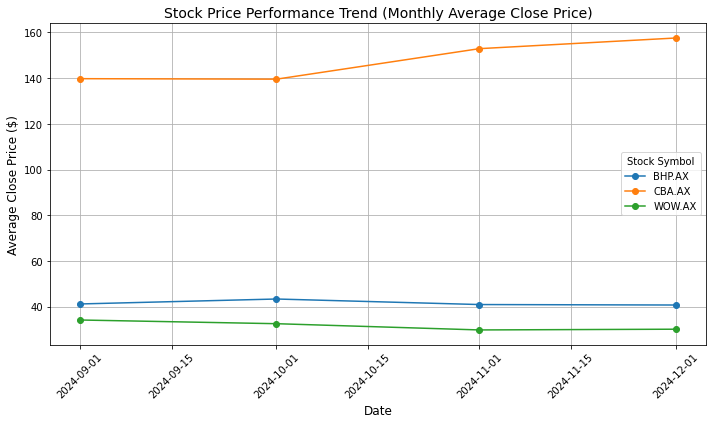

In [53]:
#Visualization
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Fetch the aggregation result and convert it to a list
stock_monthly_avg_close = list(db.historical_prices.aggregate([
    {
        "$match": {
            "date": {"$gte": datetime.datetime.utcnow() - datetime.timedelta(days=90)}  # Filter for the last 3 months
        }
    },
    {
        "$group": {
            "_id": {
                "stock_symbol": "$stock_symbol",
                "month": {"$month": "$date"},  # Extract month from date
                "year": {"$year": "$date"},   # Extract year from date
            },
            "average_close": {"$avg": "$close"}  # Calculate the average close price for each month
        }
    },
    {
        "$sort": {"_id.stock_symbol": 1, "_id.year": 1, "_id.month": 1}  # Sort by stock symbol, year, and month
    },
]))

# Step 1: Convert MongoDB aggregation result into a list of dictionaries
data = []
for record in stock_monthly_avg_close:  # Iterate through the aggregation results
    # Extract values from _id field and store relevant data
    stock_symbol = record["_id"]["stock_symbol"]
    year = record["_id"]["year"]
    month = record["_id"]["month"]
    average_close = record["average_close"]
    
    # Append extracted data to the list
    data.append({
        "stock_symbol": stock_symbol,
        "year": year,
        "month": month,
        "average_close": average_close
    })

# Step 2: Convert into a pandas DataFrame for easier manipulation
df = pd.DataFrame(data)
print(df)

# Ensure the DataFrame is not empty before proceeding
if not df.empty:
    # Check for missing values and remove them
    df = df.dropna(subset=['year', 'month'])

    # Convert year and month to integers explicitly
    df['year'] = df['year'].astype(int)
    df['month'] = df['month'].astype(int)

    # Combine year and month into a single datetime column
    df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01', format='%Y-%m-%d', errors='coerce')

    # Check if any 'date' values are invalid (NaT)
    if df['date'].isna().sum() > 0:
        print("Warning: Some date values were invalid and have been coerced to NaT.")
    
    # Step 4: Plotting the data
    plt.figure(figsize=(10, 6))

    # Plot data for each stock symbol
    for symbol in df['stock_symbol'].unique():
        stock_data = df[df['stock_symbol'] == symbol]
        # Convert data to numpy arrays to avoid the multi-dimensional indexing issue
        dates = stock_data['date'].to_numpy()
        average_close = stock_data['average_close'].to_numpy()

        # Plot using numpy arrays
        plt.plot(dates, average_close, marker='o', label=symbol)
        
    # Adding labels and title
    plt.title("Stock Price Performance Trend (Monthly Average Close Price)", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Average Close Price ($)", fontsize=12)
    plt.legend(title="Stock Symbol")
    plt.grid(True)

    # Show the plot
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No data available for visualization.")


# 3.1.c. Stocks with Their Latest Price and Market Events 

This query retrieves the latest price for each stock along with the most recent market event related to that stock, including stock symbol and event title. It can help us to figure out what market event happened recently that could influence that stock's price?

In [63]:
latest_price_market_events = db.stocks.aggregate([
    {"$lookup": {
        "from": "real_time_prices", 
        "localField": "stock_symbol", 
        "foreignField": "stock_symbol", 
        "as": "latest_prices"
    }},  # Join with real-time prices
    {"$unwind": "$latest_prices"},  # Flatten the real-time prices array
    {"$lookup": {
        "from": "market_events",
        "localField": "stock_symbol",
        "foreignField": "related_stocks",
        "as": "recent_events"
    }},  # Join with market events
    {"$unwind": "$recent_events"},  # Flatten the market events array
    {"$sort": {"latest_prices.timestamp": -1}},  # Sort by the most recent price
    {"$project": {
        "_id": 0, 
        "stock_symbol": 1, 
        "company_name": 1, 
        "latest_price": "$latest_prices.price", 
        "event_title": "$recent_events.title",
        "event_date": "$recent_events.date"
    }}  # Format the result
])
print_cursor(latest_price_market_events)


{'stock_symbol': 'WOW.AX', 'company_name': 'Woolworths Group Limited', 'latest_price': 30.15999984741211, 'event_title': 'Calculating The Fair Value Of Woolworths Group Limited (ASX:WOW)', 'event_date': datetime.datetime(2024, 11, 19, 0, 0)}

{'stock_symbol': 'WOW.AX', 'company_name': 'Woolworths Group Limited', 'latest_price': 30.15999984741211, 'event_title': "Some Investors May Be Willing To Look Past Woolworths Group's (ASX:WOW) Soft Earnings", 'event_date': datetime.datetime(2024, 3, 9, 0, 0)}

{'stock_symbol': 'WOW.AX', 'company_name': 'Woolworths Group Limited', 'latest_price': 30.15999984741211, 'event_title': 'Woolworths Group Full Year 2024 Earnings: EPS Beats Expectations', 'event_date': datetime.datetime(2024, 8, 29, 0, 0)}

{'stock_symbol': 'WOW.AX', 'company_name': 'Woolworths Group Limited', 'latest_price': 30.15999984741211, 'event_title': 'Australian competition regulator sues Woolworths, Coles over discount claims', 'event_date': datetime.datetime(2024, 9, 23, 0, 0)}


# 3.1.d. Sentiment distribution
The purpose of analyzing the sentiment distribution (i.e., counting how many commentaries are Positive, Negative, or Neutral) is to understand how the market or news sentiment is trending for the stocks you're monitoring.

In [61]:
# Perform the aggregation to get sentiment distribution
sentiment_distribution = db.market_events.aggregate([
    {
        "$group": {
            "_id": "$related_stocks",  # Group by stock symbol
            "PositiveCount": {
                "$sum": { "$cond": [{ "$eq": ["$sentiment", "Positive"] }, 1, 0] }
            },
            "NegativeCount": {
                "$sum": { "$cond": [{ "$eq": ["$sentiment", "Negative"] }, 1, 0] }
            },
            "NeutralCount": {
                "$sum": { "$cond": [{ "$eq": ["$sentiment", "Neutral"] }, 1, 0] }
            }
        }
    },
    {
        "$project": {
            "StockSymbol": "$_id",  # Rename _id to stockSymbol
            "_id": 0,  # Remove the _id field from the result
            "PositiveCount": 1,
            "NegativeCount": 1,
            "NeutralCount": 1
        }
    }
])

print_cursor(sentiment_distribution)


{'PositiveCount': 8, 'NegativeCount': 4, 'NeutralCount': 3, 'StockSymbol': 'CBA.AX'}

{'PositiveCount': 17, 'NegativeCount': 5, 'NeutralCount': 4, 'StockSymbol': 'BHP.AX'}

{'PositiveCount': 4, 'NegativeCount': 3, 'NeutralCount': 0, 'StockSymbol': 'WOW.AX'}



--> For example, the sentiment distribution for "CBA.AX" shows that most commentaries are positive (8), with a few neutral (3) and negative (4), indicating generally favorable market perception with some mixed or concerned views.

# 3.2. Nested Array Query

In [80]:
# Aggregation query
pipeline = [
    {
        # Step 1: Match the event by title
        "$match": {
            "title": "Commonwealth Bank of Australia (ASX:CBA) Has Announced That It Will Be Increasing Its Dividend To A$2.50"
        }
    },
    {
        # Step 2: Lookup related stock historical prices
        "$lookup": {
            "from": "historical_prices",  # The collection with historical prices
            "localField": "related_stocks",  # Reference to the related stocks field in market_events
            "foreignField": "stock_symbol",  # Join on stock_symbol in the historical_prices collection
            "as": "historical_data"
        }
    },
    {
        # Step 3: Filter historical prices after the event date
        "$addFields": {
            "filtered_prices": {
                "$filter": {
                    "input": "$historical_data",  # Array of historical prices
                    "as": "price",  # Alias for each element
                    "cond": {
                        "$gte": ["$$price.date", "$date"]  # Filter prices with dates >= event date
                    }
                }
            }
        }
    },
    {
        # Step 4: Get the first price after the event
        "$addFields": {
            "first_price_after_event": { 
                "$arrayElemAt": ["$filtered_prices", 0]  # Get the first element from the filtered array
            }
        }
    },
    {
        # Step 5: Project only the required fields (stock symbol, date, first open price)
        "$project": {
            "stock_symbol": {
                "$cond": {
                    "if": {"$isArray": "$related_stocks"},
                    "then": {"$arrayElemAt": ["$related_stocks", 0]},
                    "else": "$related_stocks"
                }
            },
            "date": "$first_price_after_event.date",  # The date of the first price after the event
            "first_open_price": "$first_price_after_event.open",  # The open price of the first price after the event
            "_id": 0  # Exclude the _id field from the result
        }
    }
]

# Run the aggregation query
result = db.market_events.aggregate(pipeline)

# Print the results
for document in result:
    print(f"Stock Symbol: {document['stock_symbol']}")
    print(f"First Open Price: {document['first_open_price']}")
    print("-" * 40)


Stock Symbol: CBA.AX
First Open Price: 140.8699951171875
----------------------------------------


# Part 4: Real-Time Operations

In the below simulation, I tried to fetch real-time stock prices for CBA.AX using the yfinance library, stores the data in the Real-Time Prices collection, and generates live commentary on stock price changes, which is inserted into the Live Commentary collection every 1 minute. However, somehow it doesn't insert data in the database. Therefore, I created another simulation with the same logic but fetched by fake data later. 

In [76]:
# Function to fetch real-time stock prices
import time
def fetch_real_time_price(symbol):
    try:
        ticker = yf.Ticker(symbol)
        history = ticker.history(period="1d")
        
        if history.empty:
            print(f"No real-time data for {symbol}.")
            return None
        
        latest_data = history.iloc[-1]
        latest_price = latest_data["Close"]
        volume = int(latest_data["Volume"])

        return latest_price, volume

    except Exception as e:
        print(f"Error fetching real-time price for {symbol}: {e}")
        return None

# Function to generate live commentary based on price change
def generate_live_commentary(symbol, prev_price=None):
    try:
        latest_price, volume = fetch_real_time_price(symbol)
        
        if latest_price is None:
            return None, prev_price

        # Check if there is a price change
        if prev_price is None:
            prev_price = latest_price
            return None, prev_price
        
        # Calculate the price change percentage
        price_change_percentage = ((latest_price - prev_price) / prev_price) * 100
        
        # Generate commentary based on price change
        if price_change_percentage > 0:
            commentary = f"The stock price of {symbol} has increased by {price_change_percentage:.2f}%."
        elif price_change_percentage < 0:
            commentary = f"The stock price of {symbol} has decreased by {abs(price_change_percentage):.2f}%."
        else:
            commentary = f"The stock price of {symbol} has not changed."
        
        # Store the real-time price in the real_time_prices collection
        real_time_prices.insert_one({
            "stock_symbol": symbol,
            "timestamp": datetime.datetime.utcnow(),
            "price": latest_price,
            "volume": volume
        })
        
        # Store the commentary in the live_commentary collection
        live_commentary.insert_one({
            "stock_symbol": symbol,
            "timestamp": datetime.datetime.utcnow(),
            "content": commentary
        })
        
        print(f"Live commentary inserted for {symbol}: {commentary}")
        
        # Return the latest price for comparison in the next iteration
        return prev_price, latest_price
    
    except Exception as e:
        print(f"Error generating live commentary for {symbol}: {e}")
        return prev_price, prev_price


# Function to populate live commentary and real-time prices for multiple symbols
def populate_live_data(symbols, num_requests=5, delay=60):
    for symbol in symbols:
        prev_price = None
        
        # Generate live commentary multiple times for each symbol
        for _ in range(num_requests):
            prev_price, _ = generate_live_commentary(symbol, prev_price)
            time.sleep(delay)  # Wait for the specified delay before the next request

# Example usage
symbols = ["CBA.AX"]  # List of stock symbols

# Call the function to populate live commentary and real-time prices for each symbol
populate_live_data(symbols, num_requests=5, delay=60)

With the same logic with the code above, I set up a simulation to add real-time commentary updates about stock price change but with the fake data, that inserts a comment into the Live Commentary collection every 10 seconds during trading hour stock market.

In [75]:
import datetime
import time
import random
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")  
db = client["stock_data"]
real_time_prices = db["real_time_prices"]
live_commentary = db["live_commentary"]

# Generate fake stock prices and volume
def fetch_fake_real_time_price(symbol):
    price = round(random.uniform(50, 200), 2)  # Random price between 50 and 200
    volume = random.randint(1000, 10000)  # Random volume between 1,000 and 10,000
    print(f"Fetched fake data for {symbol}: Price = {price}, Volume = {volume}")
    return price, volume

# Generate live commentary 
def generate_live_commentary(symbol, prev_price=None):
    try:
        latest_price, volume = fetch_fake_real_time_price(symbol)
        
        # Check if there is a price change
        if prev_price is None:
            prev_price = latest_price
            print(f"First price for {symbol}: {latest_price}")
            return prev_price, latest_price

        # Calculate price change percentage
        price_change_percentage = ((latest_price - prev_price) / prev_price) * 100
        
        # Generate commentary
        if price_change_percentage > 0:
            commentary = f"The stock price of {symbol} has increased by {price_change_percentage:.2f}%."
        elif price_change_percentage < 0:
            commentary = f"The stock price of {symbol} has decreased by {abs(price_change_percentage):.2f}%."
        else:
            commentary = f"The stock price of {symbol} has not changed."
        
        real_time_prices.insert_one({
            "stock_symbol": symbol,
            "timestamp": datetime.datetime.utcnow(),
            "price": latest_price,
            "volume": volume
        })
        live_commentary.insert_one({
            "stock_symbol": symbol,
            "timestamp": datetime.datetime.utcnow(),
            "content": commentary
        })
        print(f"Inserted data for {symbol}: Price = {latest_price}, Commentary = {commentary}")
        
        return prev_price, latest_price
    
    except Exception as e:
        print(f"Error generating live commentary for {symbol}: {e}")
        return prev_price, prev_price

# Populate live data for multiple symbols
def populate_live_data(symbols, num_requests=5, delay=10):
    for symbol in symbols:
        prev_price = None
        for _ in range(num_requests):
            prev_price, _ = generate_live_commentary(symbol, prev_price)
            time.sleep(delay)

# Example usage
symbols = ["CBA.AX"]  
populate_live_data(symbols, num_requests=5, delay=10)

Fetched fake data for CBA.AX: Price = 118.91, Volume = 4452
First price for CBA.AX: 118.91
Fetched fake data for CBA.AX: Price = 156.95, Volume = 1398
Inserted data for CBA.AX: Price = 156.95, Commentary = The stock price of CBA.AX has increased by 31.99%.
Fetched fake data for CBA.AX: Price = 72.94, Volume = 9896
Inserted data for CBA.AX: Price = 72.94, Commentary = The stock price of CBA.AX has decreased by 38.66%.
Fetched fake data for CBA.AX: Price = 108.64, Volume = 9153
Inserted data for CBA.AX: Price = 108.64, Commentary = The stock price of CBA.AX has decreased by 8.64%.
Fetched fake data for CBA.AX: Price = 111.77, Volume = 3774
Inserted data for CBA.AX: Price = 111.77, Commentary = The stock price of CBA.AX has decreased by 6.00%.
